# Introduction

The purpose of this project is to determine which aircraft make and models are the most likely to suffer safety incidents in order to inform the purchasing decisions of aviation stakeholders. The project will make recommendations about which aircraft are likely to be unsafe, but will also make recommendations about which aircraft are the least likely to suffer a safety incident.

# Step 1: import packages and read the CSV into memory

First things first, let's set the stage for the analysis. We'll need to import all the packages we intend to use, and load our data into the memory of the notebook as a pandas dataframe. I've done all of this and also displayed a preview of the data in the cell below.

In [1]:
#import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#load csv as dataframe and display preview
df = pd.read_csv('data/Aviation_Data.csv', low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Step 2: remove as many uncessary columns as possible

Next, we need to narrow the scope of our analysis to only what is relevant to the core business question. I did extensive exploration of the data before making a decision about which variables are relevant to my analysis, so it's most efficient for me to just drop the columns I don't plan to use right off the bat.

In [2]:
#drop all of the columns I do not plan to use in my analysis
df=df.drop(axis=1, labels=
        ['Investigation.Type', 'Accident.Number', 'Amateur.Built', 'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Aircraft.Category', 'Registration.Number', 'FAR.Description', 'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Broad.phase.of.flight', 'Publication.Date', 'Report.Status']
       )

Now, let's get a general summary of the missing and duplicate values in the data.

In [3]:
#Display the total number of NaN entires in each column.
df.isna().sum()

Event.Id                   1459
Event.Date                 1459
Injury.Severity            2459
Aircraft.damage            4653
Make                       1522
Model                      1551
Number.of.Engines          7543
Engine.Type                8536
Total.Fatal.Injuries      12860
Total.Serious.Injuries    13969
Total.Minor.Injuries      13392
Total.Uninjured            7371
Weather.Condition          5951
dtype: int64

In [4]:
### find total number of duplicate rows
df.duplicated().value_counts()

False    88846
True      1502
dtype: int64

# Step 3: Clean the data

## Dropping Duplicates
First, let's just remove all the duplicated records. This will be nice and easy!

In [5]:
#drop all duplicate rows and confirm there are no more duplicates
df = df.drop_duplicates()
df.duplicated().value_counts()

False    88846
dtype: int64

## Placeholders and Missing Values

### Event ID
Now, we need to remove or fill in the missing and placeholder values. I've determined that the best way to do this will be to just go through the relevant columns and decide how to handle them on a case-by-case basis. I don't plan to use Event ID as much other than a unique tracker of each case, so I won't be doing anything fancy with it - instead, I'm just going to drop the missing entries and call this one done.

In [6]:
#Remove all NaNs from Event Id
df=df.dropna(subset=['Event.Id'])

### Injury Severity
Next, I will work with the injury severity column. The data in this column is extremely irregular and redundant with other columns in the dataframe, but I think a simple fatal or non-fatal distinction is useful to me, so I will simplify it to that.

In [7]:
#Show the irregular data contained in this column
df['Injury.Severity'].value_counts().head(20)

Non-Fatal      67336
Fatal(1)        6165
Fatal           5262
Fatal(2)        3705
Incident        2211
Fatal(3)        1146
Fatal(4)         808
Fatal(5)         235
Minor            217
Serious          173
Fatal(6)         161
Unavailable       96
Fatal(7)          56
Fatal(8)          51
Fatal(10)         32
Fatal(9)          18
Fatal(14)         11
Fatal(11)         10
Fatal(13)          9
Fatal(12)          8
Name: Injury.Severity, dtype: int64

In [8]:
#This cell standardizes the non-fatal values and drops unkowns/NaNs.
df['Injury.Severity'] = df['Injury.Severity'].replace(to_replace=['Incident', 'Minor', 'Serious'], value='Non-Fatal')
df = df.drop(df[df['Injury.Severity'] == 'Unavailable'].index)
df.dropna(axis=0, subset=['Injury.Severity'], inplace=True)
df['Injury.Severity'].value_counts().head(20)

Non-Fatal    69937
Fatal(1)      6165
Fatal         5262
Fatal(2)      3705
Fatal(3)      1146
Fatal(4)       808
Fatal(5)       235
Fatal(6)       161
Fatal(7)        56
Fatal(8)        51
Fatal(10)       32
Fatal(9)        18
Fatal(14)       11
Fatal(11)       10
Fatal(13)        9
Fatal(12)        8
Fatal(20)        5
Fatal(18)        5
Fatal(15)        5
Fatal(23)        4
Name: Injury.Severity, dtype: int64

In [9]:
#This cell standardizes the Fatal entries based on their length. Anything longer than 5 characters is just set to 'Fatal'.
df['Injury.Severity'] = df['Injury.Severity'].map(lambda x: 'Fatal' if x[:5]=='Fatal' else x)

In [10]:
#Display the cleaned column
df['Injury.Severity'].value_counts()

Non-Fatal    69937
Fatal        17813
Name: Injury.Severity, dtype: int64

### Make and Model
The next two columns are the most important in the dataset. They will enable my analysis by allowing me to track the individual makes and models of the planes in the data, so that I can determine which ones are the safest.

In [11]:
#Now I need to handle the make and model columns. They are both categorical, do not have placeholder values, and only have a 
#small amount of missing values, which it will be convenient for me to just drop.

df['Make'].value_counts().head(20)

Cessna               22201
Piper                12016
CESSNA                4841
Beech                 4326
PIPER                 2814
Bell                  2116
Boeing                1530
Mooney                1092
Grumman               1091
BEECH                 1025
Robinson               941
Bellanca               886
Hughes                 794
BOEING                 720
Schweizer              627
Air Tractor            595
BELL                   570
Mcdonnell Douglas      515
Aeronca                486
Maule                  445
Name: Make, dtype: int64

In [12]:
df.dropna(axis=0, subset=['Make'], inplace=True)

In [13]:
df['Model'].value_counts().head(20)

152          2357
172          1742
172N         1161
PA-28-140     930
150           825
172M          797
172P          685
182           656
180           622
150M          585
PA-18         579
PA-18-150     578
PA-28-180     572
PA-28-161     569
PA-28-181     530
206B          521
PA-38-112     467
150L          461
G-164A        460
A36           450
Name: Model, dtype: int64

In [14]:
df.dropna(axis=0, subset=['Model'], inplace=True)

### Number of Engines
The number of engines will only feature in my analysis as a mechanism to guage the size of the individual airplanes. I do not think it will be a big deal if I cause a change in its summary statistics, so I will just fill with the median value, since the mean would be a decimal and inconsistent with the rest of the data.

In [15]:
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    69460
2.0    10847
0.0     1205
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.143976992804184


In [16]:
#fillna with the median of the column
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

Now I need to check to see how that operation affected the data. It looks like it very slightly lowered the mean value by assuming all the NaNs were planes with 1 engine. This should be perfectly fine for my analysis, since I am working under the assumption that my stakeholders want to buy larger planes anyway, and most of these fabricated values will be ignored.

In [17]:
#print the value counts and mean of the data
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    74711
2.0    10847
0.0     1205
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.1353524982888432


### Engine Type
Now it's time for something more difficult. The engine type column is categorical and has several different placeholder values which need to be dealt with. I cannot just drop them or fill with the mean or median, so I'm going to have to do something just a little bit more creative.

In [18]:
print(df['Engine.Type'].value_counts(normalize=True).head(10))

Reciprocating    0.852199
Turbo Shaft      0.044158
Turbo Prop       0.041323
Turbo Fan        0.028866
Unknown          0.024484
Turbo Jet        0.008554
None             0.000233
Electric         0.000098
NONE             0.000025
LR               0.000025
Name: Engine.Type, dtype: float64


In [19]:
df['Engine.Type'].value_counts()

Reciprocating      69438
Turbo Shaft         3598
Turbo Prop          3367
Turbo Fan           2352
Unknown             1995
Turbo Jet            697
None                  19
Electric               8
NONE                   2
LR                     2
UNK                    1
Hybrid Rocket          1
Geared Turbofan        1
Name: Engine.Type, dtype: int64

First, I will simply drop the none values, since they are such a small subset of the total. Then, I will fill the NaNs with the 'unknown' placeholder value to simplify the following steps. 

After filling in the missing values, I plan to employ a trick that I learned from the solution branch of the [DSC dealing missing data lab solution branch](https://github.com/learn-co-curriculum/dsc-dealing-missing-data-lab/tree/solution). The repository has five contributors who are all brilliant people - thank you for making this piece of programming so easy for me to find and use! It has a function that calculates the normal distribution of the values in a column, converts them each into a percentage of the total, and then feeds those percentages to a numpy random choose function in order to assign values randomly to the placeholders according to the normal distribution of the data. 

I like this method since it tends to have a very small effect on the summary statistics of the data. A major disadvantage of this technique which must be mitigated is its randomness; if I do not set a random seed before using these calls, my analysis will yield a different result every time.

In [20]:
#Standardize placeholder values
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'NONE']
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'None']
df['Engine.Type'].fillna(value='Unknown', inplace=True)
df['Engine.Type'].value_counts(normalize=True) 

Reciprocating      0.792129
Unknown            0.093486
Turbo Shaft        0.041045
Turbo Prop         0.038410
Turbo Fan          0.026831
Turbo Jet          0.007951
Electric           0.000091
LR                 0.000023
UNK                0.000011
Hybrid Rocket      0.000011
Geared Turbofan    0.000011
Name: Engine.Type, dtype: float64

Before anything else, it is highly important to set the numpy random seed for reproducability. I want to make sure the result is exactly the same every time this notebook is run, so I set the random seed in the cell below.

In [21]:
np.random.default_rng(seed=42)

Generator(PCG64) at 0x2086A923400

Next, I need to start defining functions so that I can easily re-use this process later. The first function needs to take a df and column as input. I also want to optionally be able to include a list of values to ignore/not calculate normals for so that I can exclude placeholders and outliers.

In [22]:
def get_norms(df, column, ignore=[]):
    '''
    Returns normalized value counts of the specified column in df. Ignore is a list of values to exclude from this calculation.
    '''
    c = dict(df[column].value_counts(normalize=True))
    for key in ignore:
        del c[key]
    return list(c.values())

In [23]:
remove_list = ['Unknown', 'Electric', 'LR', 'UNK', 'Geared Turbofan', 'Hybrid Rocket']
norms = get_norms(df, 'Engine.Type', remove_list)
norms

[0.7921286789869952,
 0.04104494638375542,
 0.03840976500114077,
 0.026830937713894592,
 0.007951174994296144]

Perfect, that works exactly how I want it to. I can give my function a dataframe and the column I want the normal distribution of, and it will return a list of the values. I can even give it a list of values I want it to exclude! As a consequence of me using that to exclude the placeholder values I plan to replace, I need to re-normalize these values so they can be used as percentage chances.

In [24]:
def get_probs(normal_list):
    '''
    Takes a list as an argument and returns normalized values.
    '''
    probabilities = []
    for number in normal_list:
        probabilities.append(number/sum(normal_list))
    return probabilities

In [25]:
norms = get_probs(norms)
norms

[0.8739616372149223,
 0.04528520364496803,
 0.04237778784675024,
 0.029602779036399334,
 0.008772592256960176]

Now, I need to write the function that fills in the placeholder values according to this distribution. 

In [26]:
def impute(value, choices, chances):
    '''
    If a given value is unknown, replace it with one of the choices given according to the probabilities given.
    '''
    if value == 'Unknown':
        return np.random.choice(choices, p=chances)
    else:
        return value

Now, I just need to map this function to each value in the engine type column using a lambda function, while feeding it the list of valid options for it to choose from ordered the same as their probabilities.

In [27]:
choice_list = ['Reciprocating', 'Turbo Shaft', 'Turbo Prop', 'Turbo Fan', 'Turbo Jet'] #hard-coded list of values

df['Engine.Type'] = df['Engine.Type'].map(lambda x: impute(x, choice_list, norms))

In [28]:
df['Engine.Type'].value_counts(normalize=True)

Reciprocating      0.874139
Turbo Shaft        0.045311
Turbo Prop         0.042094
Turbo Fan          0.029614
Turbo Jet          0.008693
Electric           0.000091
LR                 0.000023
UNK                0.000011
Hybrid Rocket      0.000011
Geared Turbofan    0.000011
Name: Engine.Type, dtype: float64

It looks like that worked exactly how I wanted it to! This definitely has a smaller effect on the column than just dropping the 5% of values that are missing would, with the trade-off of being more random. There are definitely records in the data that represent real aircraft which I have filled in with an inaccurate engine type using this method; although this would have been a consequence of any method I used to fill in the blanks. Next, I'll be making heavy usage of those functions I just defined to standardize the next four columns.

My plan for the injury totals is to fill all NaN values with 'Unknown', and then apply the functions I just wrote to them in the same way to preserve the summary statistics while filling in the missing values. This is likely to have a large effect on the distribution of the data and will probably make some makes and models of planes seem safer or more dangerous than they actually are due to randomness. I am still of the opinion that this is the best method and will just do my best to mitigate the consequences of this decision.

### Total Fatal Injuries
For this column, I am going to ignore everything other than the top 5 most common values to avoid inflating outliers.

In [29]:
#This cell displays the five most common values in this column. I plan to only fill the NaNs in to these five buckets.
print(df['Total.Fatal.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.014392
3.0    0.020743
2.0    0.067520
1.0    0.116103
0.0    0.767335
Name: Total.Fatal.Injuries, dtype: float64


In [30]:
#I've shot myself in the foot by not also including an option in this function to only keep the first x number of values.
#Instead, I will manually delete everything after the first 5.
norms = get_norms(df, 'Total.Fatal.Injuries')
del norms[5:]
norms

[0.7673349658866205,
 0.11610334848028496,
 0.06751961028246664,
 0.02074303000144049,
 0.014391786598221651]

In [31]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Fatal.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Fatal.Injuries'] = df['Total.Fatal.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Fatal.Injuries'].value_counts(normalize=True).sort_values().tail(10)

10.0    0.000513
8.0     0.000787
7.0     0.001152
6.0     0.002464
5.0     0.003947
4.0     0.014545
3.0     0.020773
2.0     0.067317
1.0     0.116655
0.0     0.768595
Name: Total.Fatal.Injuries, dtype: float64

Perfect, it looks like that went off without a hitch, and had a minimal effect on summary statistics! I need to make sure there are not any NaN values left after that, and then I will repeat the same process for the next three columns.

In [32]:
df['Total.Fatal.Injuries'].isna().any()

False

### Total Serious Injuries

I will apply the exact same method to this column.

In [33]:
print(df['Total.Serious.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.003401
3.0    0.008344
2.0    0.037362
1.0    0.121147
0.0    0.826278
Name: Total.Serious.Injuries, dtype: float64


In [34]:
norms = get_norms(df, 'Total.Serious.Injuries')
del norms[5:]
norms

[0.8262781675170068,
 0.1211468962585034,
 0.037361819727891155,
 0.008343962585034014,
 0.003401360544217687]

In [35]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Serious.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Serious.Injuries'] = df['Total.Serious.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Serious.Injuries'].value_counts(normalize=True).sort_values().tail(10)

10.0    0.000148
9.0     0.000171
7.0     0.000308
6.0     0.000456
5.0     0.000890
4.0     0.003422
3.0     0.008385
2.0     0.037782
1.0     0.121150
0.0     0.826283
Name: Total.Serious.Injuries, dtype: float64

### Total Minor Injuries

Same story here, I do not have to change anything about my technique to fix this column, I just need to plug it in to my functions.

In [36]:
print(df['Total.Minor.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.004879
3.0    0.010338
2.0    0.047139
1.0    0.135944
0.0    0.795807
Name: Total.Minor.Injuries, dtype: float64


In [37]:
norms = get_norms(df, 'Total.Minor.Injuries')
del norms[5:]
norms

[0.7958069620253164,
 0.13594409282700423,
 0.04713871308016877,
 0.010337552742616034,
 0.004878691983122363]

In [38]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Minor.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Minor.Injuries'] = df['Total.Minor.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Minor.Injuries'].value_counts(normalize=True).sort_values().tail(10)

8.0    0.000228
9.0    0.000251
7.0    0.000662
6.0    0.000753
5.0    0.001460
4.0    0.004905
3.0    0.010518
2.0    0.047456
1.0    0.136299
0.0    0.795722
Name: Total.Minor.Injuries, dtype: float64

### Total Uninjured

I plan to use the same technique on this column again, but I end up finding a difference in the distribution that demands a slightly different treatment.

In [39]:
print(df['Total.Uninjured'].value_counts(normalize=True).sort_values().tail(10))

9.0    0.001564
8.0    0.001967
7.0    0.003409
6.0    0.006109
5.0    0.010825
4.0    0.032474
3.0    0.052620
2.0    0.195111
1.0    0.306447
0.0    0.352103
Name: Total.Uninjured, dtype: float64


This column has a wider distribution of values than the previous 3, so I have decided to distribute the NaNs across the top 7 values instead of top 5.

In [40]:
norms = get_norms(df, 'Total.Uninjured')
del norms[7:]
norms

[0.35210321193387983,
 0.3064470806709753,
 0.19511062784816313,
 0.052620004642582256,
 0.032473641128391836,
 0.010824547042797278,
 0.00610866085936641]

In [41]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
df['Total.Uninjured'].fillna(value='Unknown', inplace=True)
df['Total.Uninjured'] = df['Total.Uninjured'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Uninjured'].value_counts(normalize=True).sort_values().tail(10)

9.0    0.001460
8.0    0.001837
7.0    0.003183
6.0    0.006115
5.0    0.010849
4.0    0.032386
3.0    0.053103
2.0    0.195996
1.0    0.307655
0.0    0.352521
Name: Total.Uninjured, dtype: float64

This way of doing it is a bit messy and I could make it more efficient by making a fourth function that contains all of the code in the three cells I used for each of these columns. Writing that function would require me to come up with a mathematical way of detecting the 5-7 most common values, which I estimate would have taken me longer than just copy pasting the code and manually handling the exception. For my first attempt at doing something like this without direct guidance, I am quite happy with the result!

### Aircraft Damage

I need another way of judging the severity of a crash that is not just the number of people injured, so I will also be considering the damage to the airplane. I will do this by re-using the handy random choice function I learned about in that solution branch - thank you again to the contributors!

In [42]:
df['Aircraft.damage'].value_counts(normalize=True)
df['Aircraft.damage'].fillna(value='Unknown', inplace=True)

In [43]:
remove_list = ['Unknown']
norms = get_norms(df, 'Aircraft.damage', remove_list)
norms

[0.7281998631074607, 0.2109970339949806, 0.029306411133926534]

In [44]:
choice_list = ['Substantial', 'Destroyed', 'Minor']
df['Aircraft.damage'] = df['Aircraft.damage'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Aircraft.damage'].value_counts(normalize=True)

Substantial    0.751825
Destroyed      0.217910
Minor          0.030265
Name: Aircraft.damage, dtype: float64

### Total Passengers Column

Now, I want to add a new column to the dataframe to help my analysis: a sum of all the different injury type columns and the uninjured column that represents the total number of passengers on each plane at the time of the incident.

This is particularly important for my analysis, because I am working with the assumption that incidents are bound to happen. The safest plane is the one that has the smallest amount of casualties in the event of a safety incident.

In [45]:
#Simply adding all four columns together on every row
df['Total.Passengers'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries'] + df['Total.Uninjured']

### Total Injuries Column

I also realized that the total number of injuries of any type would be useful to my analysis, so I create that column here.

In [46]:
#Exactly the same as above but without uninjured passengers
df['Total.Injuries'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries']

### Weather Condition
The weather condition column has information I want to include in my visualizations, but it also has placeholder and missing values. I've already invested so much effort in the functions I used above, I think it makes a lot of sense to reuse them here again.

In [47]:
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.916564
IMC    0.070780
UNK    0.009840
Unk    0.002816
Name: Weather.Condition, dtype: float64

I plan to use this column in my analysis, so I want to make sure the data is accurate. I will re-distribute the placeholder and NaN values according to the ratio of VMC/IMC in order to preserve the summary statistics as much as possible.

In [48]:
df['Weather.Condition'].fillna(value='Unknown', inplace=True)
df.loc[df['Weather.Condition'] == 'UNK', 'Weather.Condition'] = 'Unknown'
df.loc[df['Weather.Condition'] == 'Unk', 'Weather.Condition'] = 'Unknown'
df['Weather.Condition'].value_counts(normalize=True)

VMC        0.879843
IMC        0.067944
Unknown    0.052213
Name: Weather.Condition, dtype: float64

In [49]:
norms = get_norms(df, 'Weather.Condition', remove_list)
norms

[0.8798425735797399, 0.06794433036732832]

In [50]:
choice_list = ['VMC', 'IMC']
df['Weather.Condition'] = df['Weather.Condition'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.928417
IMC    0.071583
Name: Weather.Condition, dtype: float64

Perfect! That was the last column I needed to clean, so all that's left to do before we start the analysis is a little bit of housekeeping. I have two more columns to add which will be very important to my analysis.

The first combines the make and model columns to make it easier to sort the dataframe by types of aircraft. We typically think of the individual aircraft as a combination of make and model, so it makes sense for my data to represent that. 

The second column is simply the total number of fatalities divied by the total number of passengers in each given incident, and it represents the chance that you would sustain a fatal injury if you were a passenger on that given flight. Later in the analysis I will take the average of this value for each aircraft to represent the general likilihood of dying on it based on the limited data in this dataset.

In [51]:
# Add a new column that combined make and model to simplify the code I will use in my analysis
df['Make&Model'] = df['Make'] + ' ' + df['Model']

In [52]:
# Add a new column that calculates the ratio of the mean of total fatal injuries per make and model to total passengers
df['Fatality.Ratio'] = df['Total.Fatal.Injuries']/df['Total.Passengers']
df['Fatality.Ratio'].value_counts()

0.000000    67276
1.000000    12628
0.500000     2599
0.333333     1206
0.666667      768
            ...  
0.005263        1
0.275862        1
0.085714        1
0.007353        1
0.905325        1
Name: Fatality.Ratio, Length: 301, dtype: int64

## Step 4: statistical analysis

My goal in this project is to give three concrete recommendations to stakeholders about which makes/models of plane are the best investment from a safety perspective. One of the biggest issues with investing in planes are the safety risks associated with it; if a plane is destroyed in a crash, you are not only down the money you spent on the plane, but you also have an expensive disaster to clean up. It is in the best interest of the shareholder to purchase only the most safe planes to avoid these hidden costs of the investment, since safety incidents are unfortunately common. In the event that the plane you have invested in is in a crash, you want to make sure that the crash is as minor and harmless as possible to minimize the financial damage. The three questions I will answer to address this issue in my analysis are:
1. What are the top 5 commercial-grade aircraft that have the lowest average rates of fatalities and injuries in the event of an accident?
2. Of those top 5 aircraft, which one performs the best in IMC (instrument driven only) flight conditions?
3. Of those top 5 aircraft, which plane tended to take the least damage during an incident?

### 1. Lowest fatality and injury rate among large planes

The dataset has two major challenges that I need to address before I can give advice tailored to the specific business needs of the shareholders:
1. A large amount of the makes/models in the dataset are consumer grade aircraft that are simply not relevant to the business needs of the shareholders. Some makes/models are actually helicopters, which are completely irrelevant to my analysis.
2. Many makes/models in the dataset have only 1-5 records. This may be because they are safer, or it may be because there are less of them. 

I have come up with a way to address both of these issues that I think is reasonable.
1. Commercial aircraft typically have two or more engines; in fact, according to [simpleflying.com](https://simpleflying.com/why-single-jet-commercial-aircraft-arent-just-around-the-corner/#:~:text=One%20smaller%20aircraft%20designer%20has,by%20a%20Williams%20FJ33%20turbofan.), the only single engine commericial passenger aircraft on the market is the The Cirrus Vision SF50, certified in 2016. In addition, there are many records for helicoptors, hot air baloons, and other aircraft which are irrelevant to my analysis that have 0-1 engines in the data. For this reason, it will be easiest for me to just group by number of engines and exclude all makes and models that have less than two.
2. To ensure that I am not making assumptions based on a small sample size, I will exclude all makes and models whoose number of records is less than 10. This is an arbitrary limit, and it will have a serious effect on the outcome of the analysis. However, it is my best option - Excluding outliers based on standard deviations or IQR would not be satisfactory for my needs. They would dictate that I include all aircraft with above 4 records, and I do not feel comfortable making recommendations based on a sample size of only 4 crashes. 

Another important detail to mention is that small number of incidents could mean two things: There are either not many of the aircraft/the aircraft is new and has not had enough airtime to have many incidents on record (I want to exclude these), or the aircraft is extremely safe and does not have many safety incidents (very rare). The second option would also make it very difficult to prove with this data that the aircraft is safe. I am confident that setting this arbitrary limit will allow me to make the best recommendation.

This piece of code generates the average number of total fatalities for each make and model.

In [53]:
# Group dataframe by make&model and number of engines, then calculate the mean number of fatalities for each. 
avg_fatalities = df.groupby(['Make&Model', 'Number.of.Engines'])['Total.Fatal.Injuries'].mean()
# Reset index to change object back to a dataframe
avg_fatalities = avg_fatalities.reset_index()
avg_fatalities

,Make&Model,Number.of.Engines,Total.Fatal.Injuries
0,107.5 Flying Corporation One Design DR 107,1.0,1.0
1,1200 G103,0.0,0.0
2,177MF LLC PITTS MODEL 12,1.0,0.0
3,1977 Colfer-chan STEEN SKYBOLT,1.0,1.0
4,1st Ftr Gp FOCKE-WULF 190,1.0,1.0
...,...,...,...
20737,de Havilland DHC-2 MK I,1.0,2.0
20738,de Havilland DHC-3,1.0,0.0
20739,de Havilland DHC-6-200,2.0,0.0
20740,de Havilland DHC-8-202,2.0,0.0


This piece of code calculates the mean total of injuries per incident for each aircraft.

In [54]:
# Exact same code as above, but for serious injuries instead of fatal injuries
avg_total_injuries = df.groupby(['Make&Model', 'Number.of.Engines'])['Total.Injuries'].mean()
avg_total_injuries = avg_total_injuries.reset_index()
avg_total_injuries

,Make&Model,Number.of.Engines,Total.Injuries
0,107.5 Flying Corporation One Design DR 107,1.0,1.0
1,1200 G103,0.0,1.0
2,177MF LLC PITTS MODEL 12,1.0,2.0
3,1977 Colfer-chan STEEN SKYBOLT,1.0,2.0
4,1st Ftr Gp FOCKE-WULF 190,1.0,1.0
...,...,...,...
20737,de Havilland DHC-2 MK I,1.0,5.0
20738,de Havilland DHC-3,1.0,0.0
20739,de Havilland DHC-6-200,2.0,0.0
20740,de Havilland DHC-8-202,2.0,2.0


This piece of code cacluates the total number of incidents each aircraft has been in.

In [55]:
# Find the total number of incidents for each make/model and group with the same structure.
total_incidents = df.groupby(['Make&Model', 'Number.of.Engines']).size()
# return object to df format
total_incidents = total_incidents.reset_index()
total_incidents

,Make&Model,Number.of.Engines,0
0,107.5 Flying Corporation One Design DR 107,1.0,1
1,1200 G103,0.0,1
2,177MF LLC PITTS MODEL 12,1.0,1
3,1977 Colfer-chan STEEN SKYBOLT,1.0,1
4,1st Ftr Gp FOCKE-WULF 190,1.0,1
...,...,...,...
20737,de Havilland DHC-2 MK I,1.0,1
20738,de Havilland DHC-3,1.0,1
20739,de Havilland DHC-6-200,2.0,1
20740,de Havilland DHC-8-202,2.0,1


Now that we have created the statistics we need to make the first recommendation, it's time to put them all together in a new dataframe and determine which planes have the most favorable statistics.

In [56]:
# Create a new column in one of the dataframes that is the ratio of avg fatal injuries per crash to the total number of incidents
# for each make and model.
avg_fatalities['Fatal.Ratio'] = avg_fatalities['Total.Fatal.Injuries']/total_incidents[0]

# Add the total number of incidents from the other DF to this one as a new column
avg_fatalities['Total.Incidents'] = total_incidents[0]

# Exclude all records of aircraft with less than two engines
avg_fatalities = avg_fatalities[avg_fatalities['Number.of.Engines'] >= 2]

# Move the lowest and most favorable ratios to the top of the list so it is easier to grab them
avg_fatalities = avg_fatalities.sort_values(by='Fatal.Ratio')

# Exclude every make and model combination that has less than 10 total records
avg_fatalities = avg_fatalities[avg_fatalities['Total.Incidents'] >= 10]

avg_fatalities['Total.Injuries'] = avg_total_injuries['Total.Injuries']

# Display the top 20 aircraft that meet all of these criteria 

avg_fatalities = avg_fatalities.sort_values(by=['Fatal.Ratio', 'Total.Injuries']).head(20)
avg_fatalities

,Make&Model,Number.of.Engines,Total.Fatal.Injuries,Fatal.Ratio,Total.Incidents,Total.Injuries
6253,Cessna 310B,2.0,0.000000,0.000000,11,0.000000
18400,Short Brothers SD3-60,2.0,0.000000,0.000000,10,0.000000
4046,Boeing 727-100,3.0,0.000000,0.000000,11,0.181818
2578,BOMBARDIER INC CL-600-2B19,2.0,0.000000,0.000000,15,0.333333
2479,BOEING 777,2.0,0.000000,0.000000,11,0.363636
4266,Boeing 757,2.0,0.000000,0.000000,12,0.416667
6397,Cessna 650,2.0,0.000000,0.000000,11,0.454545
5250,CESSNA 402C,2.0,0.000000,0.000000,15,0.466667
17872,Saab-scania Ab (saab) 340B,2.0,0.000000,0.000000,13,0.692308
13538,Mcdonnell Douglas MD-83,2.0,0.000000,0.000000,11,0.727273


Great! We've cut out the irrelevant records to this analysis and re-organized them according to which ones are the safest to be in during a crash. As you can see, the safest planes in this dataset do not have any fatalities on record, so we can assume the safest plane will probably have a fatal ratio of 0.0, so we can narrow our frame of attention and decide based on the number of total injuries. Now, let's make a visualization of this result!

In [57]:
avg_fatalities.drop(labels=['Number.of.Engines', 'Total.Incidents'], axis=1, inplace=True)

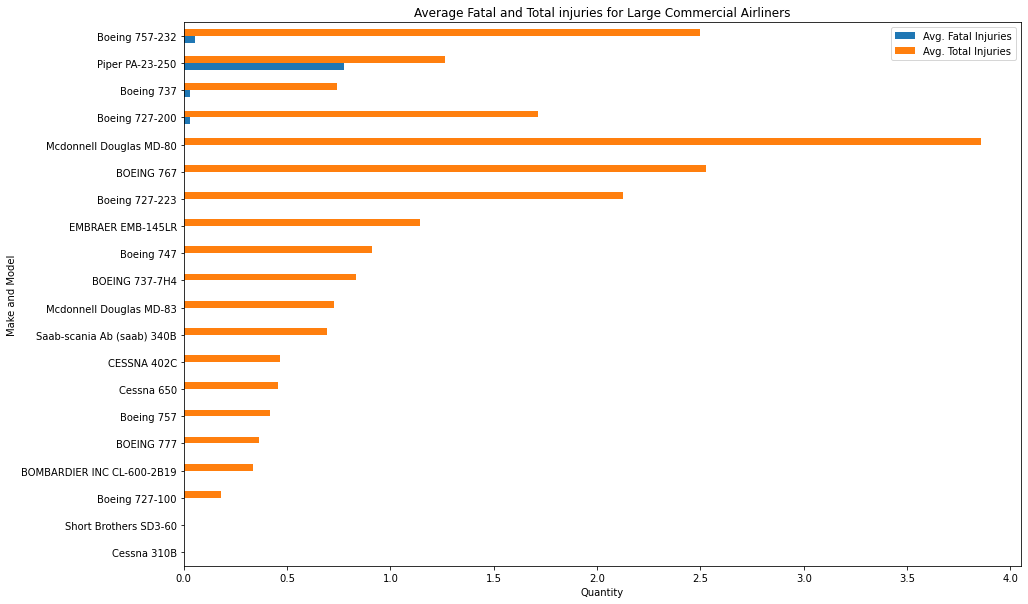

In [58]:
ax = avg_fatalities.plot.barh(y=['Total.Fatal.Injuries', 'Total.Injuries'], figsize=(15,10), xlabel='Make and Model', ylabel='Quantity')
ax.set_yticklabels(avg_fatalities['Make&Model'])
ax.set_xlabel('Quantity')
ax.set_title('Average Fatal and Total injuries for Large Commercial Airliners')
ax.legend(labels=['Avg. Fatal Injuries', 'Avg. Total Injuries']);

This graph shows a comparison of average total injuries per incident vs average fatal injuries per incident for the top 20 aircraft with the lowest values for each. The Cessna 310B has snuck in as the statistically safest aircraft, but it does not fulfill the business needs of the shareholders and will be excluded. My statistical analysis has determined that the top 5 overall safest commercial aircraft are:

1.De Havilland DHC-8-102

2.BOMBARDIER INC CL-600-2B19

3.BOEING 777

4.Boeing 727-100

5.CESSNA 402C

These are all excellent choices for investment due to their fatality-free safety record and low average numbers of injury during a crash. This implies that these planes have effective safety features that keep passengers protected in the event of a safety incident.

### 2. Performance during poor weather conditions

For the next two analyses, I will focus in on those top 5 safest planes in an attempt to determine which one is the overall safest by considering other factors. First, I will focus on their performance in poor weather conditions. The outcome of this analysis will show us the efficacy of the instrumental systems of these aircraft. If you are flying in poor conditions, the last thing you want to be dealing with as a pilot are failing instruments.

In [59]:
# This is absolutely cursed but I couldn't come up with another way of doing this. I want to only keep the rows that belong to
# one of my top 5 make and models, while keeping everything else the same.
num1 = df.loc[(df['Make&Model'] == 'De Havilland DHC-8-102')]
num2 = df.loc[(df['Make&Model'] == 'BOMBARDIER INC CL-600-2B19')]
num3 = df.loc[(df['Make&Model'] == 'BOEING 777')]
num4 = df.loc[(df['Make&Model'] == 'Boeing 727-100')]
num5 = df.loc[(df['Make&Model'] == 'CESSNA 402C')]

top5 = num1.append([num2, num3, num4, num5])
top5

,Event.Id,Event.Date,Injury.Severity,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Total.Passengers,Total.Injuries,Make&Model,Fatality.Ratio
28547,20001212X17430,1991-07-16,Non-Fatal,Minor,De Havilland,DHC-8-102,2.0,Turbo Prop,0.0,0.0,0.0,5.0,VMC,5.0,0.0,De Havilland DHC-8-102,0.0
29720,20001211X13942,1992-01-12,Non-Fatal,Minor,De Havilland,DHC-8-102,2.0,Turbo Prop,0.0,0.0,0.0,33.0,VMC,33.0,0.0,De Havilland DHC-8-102,0.0
32057,20001211X11664,1993-01-08,Non-Fatal,Substantial,De Havilland,DHC-8-102,2.0,Turbo Prop,0.0,0.0,0.0,9.0,VMC,9.0,0.0,De Havilland DHC-8-102,0.0
32404,20001211X12029,1993-03-23,Non-Fatal,Substantial,De Havilland,DHC-8-102,2.0,Turbo Prop,0.0,1.0,0.0,21.0,VMC,22.0,1.0,De Havilland DHC-8-102,0.0
37018,20001207X03251,1995-04-03,Non-Fatal,Destroyed,De Havilland,DHC-8-102,2.0,Turbo Prop,0.0,0.0,0.0,20.0,VMC,20.0,0.0,De Havilland DHC-8-102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76638,20150210X74239,2015-02-10,Non-Fatal,Substantial,CESSNA,402C,2.0,Reciprocating,0.0,0.0,0.0,7.0,VMC,7.0,0.0,CESSNA 402C,0.0
80046,20170222X25255,2017-02-11,Non-Fatal,Substantial,CESSNA,402C,2.0,Reciprocating,0.0,0.0,0.0,9.0,VMC,9.0,0.0,CESSNA 402C,0.0
87313,20210430103002,2021-04-22,Non-Fatal,Substantial,CESSNA,402C,2.0,Reciprocating,0.0,0.0,0.0,1.0,VMC,1.0,0.0,CESSNA 402C,0.0
87337,20210430103000,2021-04-26,Non-Fatal,Substantial,CESSNA,402C,2.0,Reciprocating,0.0,0.0,0.0,2.0,VMC,2.0,0.0,CESSNA 402C,0.0


In [60]:
# This code generates a grouped pivot which shows the sum total of injuries sustained under each weather condition. Higher values are worse.
top5weather = top5.groupby(['Make&Model', 'Weather.Condition']).sum()
top5weather = top5weather.reset_index()
weatherpivot = top5weather.pivot(index='Make&Model', columns='Weather.Condition', values='Total.Injuries')
weatherpivot

Weather.Condition,IMC,VMC
Make&Model,,
BOEING 777,0.0,41.0
BOMBARDIER INC CL-600-2B19,2.0,3.0
Boeing 727-100,NaN,2.0
CESSNA 402C,7.0,5.0
De Havilland DHC-8-102,NaN,3.0


Two of these makes and models have not had any safety incidents that resulted in injuries in instrumental meteorological conditions. This does not necessarily make them more safe, it just means I cannot make a ruling on them one way or the other. Let's visualize these results.

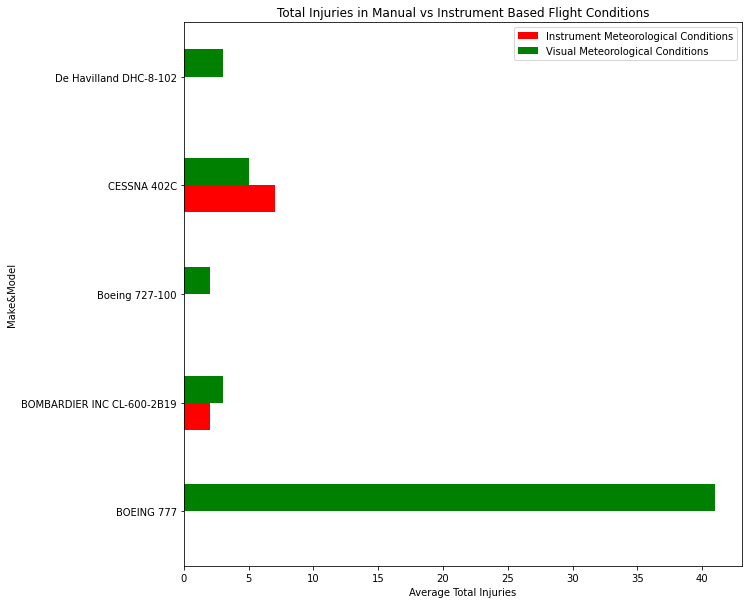

In [61]:
# Create a grouped barplot of the pivot
ax = weatherpivot.plot.barh(figsize = (10,10), color=['red', 'green'])
ax.set_xlabel('Average Total Injuries')
ax.set_title('Total Injuries in Manual vs Instrument Based Flight Conditions')
ax.legend(labels=['Instrument Meteorological Conditions', 'Visual Meteorological Conditions']);

From this graph, the Boeing 777 may immediately jump out as the worst option. However, it must be acknolwedged that it is one of the most widely used commericial airliners, and as a consequence naturally has a high number of total incidents. However, the ratio of injuries in good/bad weather conditions imply that most of the injuries in these incidents are due to human error - they happened when humans were controlling the plane. During poor weather conditions when the instruments are in control of the plane, injuries seem to be much less common. This implies that the Boeing 777 has excellent safety features and instruments.

The Bombardier CL-600 is also a standout candidate in this analyis. It also seems to have instruments and safety features that lower the liklihood of being injured in the event of a safety incident. 

In conclusion, the Boeing 777 and Bombardier CL-600 perform the best in poor weather out of the top 5 least fatal aircraft.

### 3. Damage Sustained During Crashes

In my final analysis, I will look at the totals of different categories of damage sustained by the aircraft in safety incidents and use this information to break the tie between the Boeing 777 and Bombardier CL-600. This analysis will allow us to determine which of the top 5 planes is least likely to be destroyed/need major repairs in the inevitabal event of a safety incident.

In [62]:
# Create a new grouped pivot table that has a count of how many times each category of aircraft damage appears associated with each make and model.
top5damage = top5.groupby(['Make&Model', 'Aircraft.damage']).size()
top5damage = top5damage.reset_index()
top5damage = top5damage.pivot(index='Make&Model', columns='Aircraft.damage', values=0)
top5damage

Aircraft.damage,Destroyed,Minor,Substantial
Make&Model,,,
BOEING 777,6,17,20
BOMBARDIER INC CL-600-2B19,1,6,9
Boeing 727-100,1,5,5
CESSNA 402C,1,5,10
De Havilland DHC-8-102,1,2,7


This looks great, we have a table that shows us the total of each category for each aircraft. Some aircraft have not ever had an incident where they were destroyed, which is interesting and useful to my analysis.

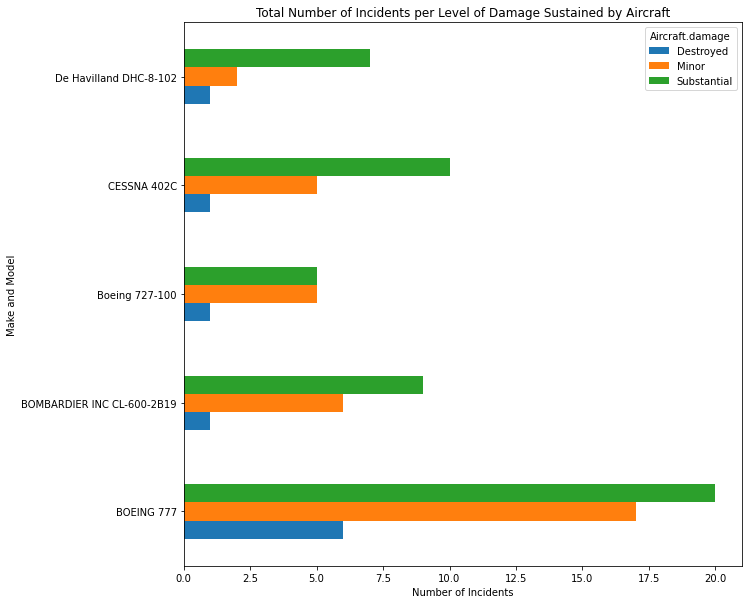

In [63]:
ax = top5damage.plot.barh(figsize=(10,10))
ax.set_xlabel('Number of Incidents')
ax.set_ylabel('Make and Model')
ax.set_title('Total Number of Incidents per Level of Damage Sustained by Aircraft');

Looking at this chart, there are several considerations that must be made and several conclusions that can be drawn. 

The first thing we must do is to acknowledge that these are not averages; they are sum totals. Planes that are more common necessarily have more records, and have a higher chance of experiencing at least one destruction. Just because the Boeing 777 has had a large amount of crashes does not mean it is inherently unsafe. However, the proportion of complete destructions of the plane to total number of incidents is still quite high.

According to this graph, it really looks like the 777 is not the best choice for an investor. The Bombardier CL-600 has a small number of incidents despite its long service life, and since it was introduced, it has never experienced an incident that was so severe the aircraft was destroyed. This aircraft continues to come out on top of my analysis, so I am confident in naming it as the best investment in a commercial aircraft from a safety standpoint. This plane is the least likely to be destroyed or need major repairs in the event of a major safety incident, meaning that it is likely to cost investors less money in the long run. 

## Conclusion

In conclusion, my analysis has found that the Bombardier CL-600 has proven itself to be the most safe and reliable aircraft in this dataset, based on its long service life and few incidents. The data shows that its instruments are highly effective at controlling the aircraft in the event of inclimate weather, and it has never experienced a crash that completely destroyed the aircraft - something that cannot be said of the Boeing 777, which has had a similarly long service life. I am confident in recommending this aircraft to investors from a safety perspective, and believe that this analysis is not only a strong selling point for them; but also for their clientele. I believe that their best business model with this plane will be to charter private luxury flights for high-ranking business clients, who are likely to resonate with an advertising message about the safety of the planes.